In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from statistics import NormalDist
from sklearn.linear_model import LinearRegression

# Data wrangling

In [502]:
#File where histogram data is stored
# histogramFile = '../PeakDetection_test_Co60_Areas.csv'
histogramFile = '../PeakDetection_Co60_Areas_2kV_v4_t100.csv'

#Ease radionuclei interchange (column name in dataframe)
radionucleiName = "Co60"

In [503]:
df = pd.read_csv(histogramFile, index_col = 0)

In [504]:
df

Co60
0       13942
1        1925
2        7308
3        1296
4        2755
...       ...
152903   1967
152904   2358
152905   2152
152906   1674
152907   2979

[152908 rows x 1 columns]

# Parameters definition

In [505]:
nBinsFit = int(2*(len(df[radionucleiName])**(2/5.0)))

In [506]:
nBinsFit

237

<IPython.core.display.Javascript object>


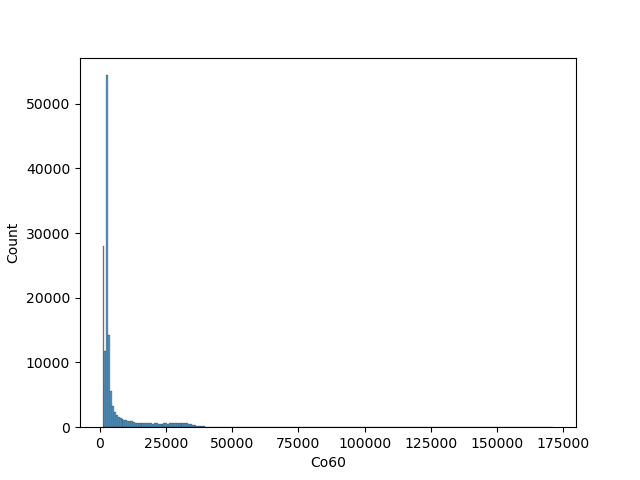

In [507]:
%matplotlib notebook
sns.histplot(df[radionucleiName], bins = nBinsFit)
# sns.histplot(df[radionucleiName], bins = nBinsFit)
plt.show()

In [542]:
#Limits within the desired energy range is constrained to
regionOfInterest = [25000,42000] #Co60 2kV
# regionOfInterest = [14500,21000] #Cs137 2kV
# regionOfInterest = [10000,16000] #Na22 2kV
# regionOfInterest = [6000,8500] #Co60 1k7V
# regionOfInterest = [4100,5200] #Cs137 1k7V
roi = regionOfInterest

In [543]:
dfConstrained = df.loc[(df[radionucleiName] > roi[0]) & (df[radionucleiName] < roi[1])]
dfConstrained

Co60
19      31104
34      32575
58      25010
91      28879
92      28148
...       ...
152841  34480
152845  31080
152846  28430
152858  26997
152885  35845

[9902 rows x 1 columns]

# Normal distribution regression

In [544]:
def computeNumberOfBins(dataLen, algorithm = 0):
    
    # D'Agostini and Stephens method
    if algorithm == 0:
        return int(2*dataLen**(2/5))
    
    
    # Sturge's rule
    elif algorithm == 1:
        return int(1 + np.log(dataLen)/np.log(2))
    
    
    # Mann and Wald method
#     elif algorithm == 2:
#         return (4*(2*(dataLen+1)**2)**(1/5))

In [545]:
#Using these values just as an estimate. Least-squares fit will be done later with scipy.optimize.curve_fit

dist = [np.average(dfConstrained[radionucleiName]), np.std(dfConstrained[radionucleiName])]
print("Average: " + str(dist[0]))
print("STDev:   " + str(dist[1]))

Average: 31103.70319127449
STDev:   3830.3385406990196


In [546]:
normDist = NormalDist.from_samples(dfConstrained[radionucleiName])

In [547]:
normDist.mean

31103.70319127449

In [548]:
normDist.stdev

3830.5319677179878

<IPython.core.display.Javascript object>


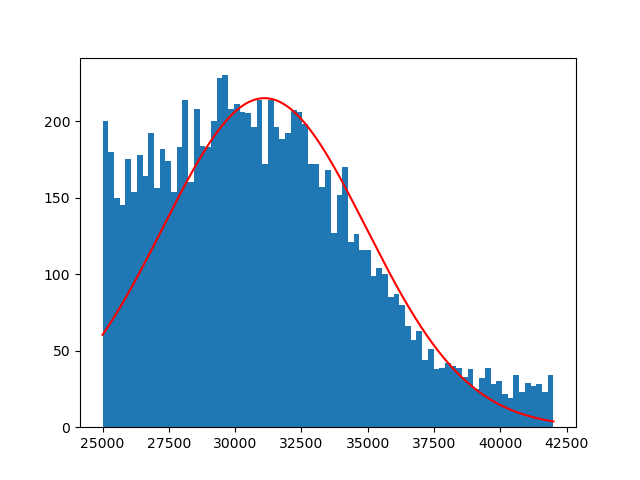

In [549]:
%matplotlib notebook

nBins = computeNumberOfBins(len(dfConstrained), 0)


# histData = sns.histplot(dfConstrained[radionucleiName], bins = nBins)
histData = plt.hist(dfConstrained[radionucleiName], bins = nBins, histtype = 'stepfilled')

denormalization = 215
edgeCuts = 0


#Estimated normalization. Further gaussian regression will be carried out later

pdfX = range(roi[0]+edgeCuts, roi[1]-edgeCuts)
pdfY = norm.pdf(pdfX, dist[0], dist[1])
pdfY /= max(pdfY)
plt.plot(pdfX, pdfY*denormalization, 'r')
plt.show()

### Extracting gaussian points for least-squares fit

In [550]:
histX = histData[1][:-1]
histY = histData[0]

<IPython.core.display.Javascript object>


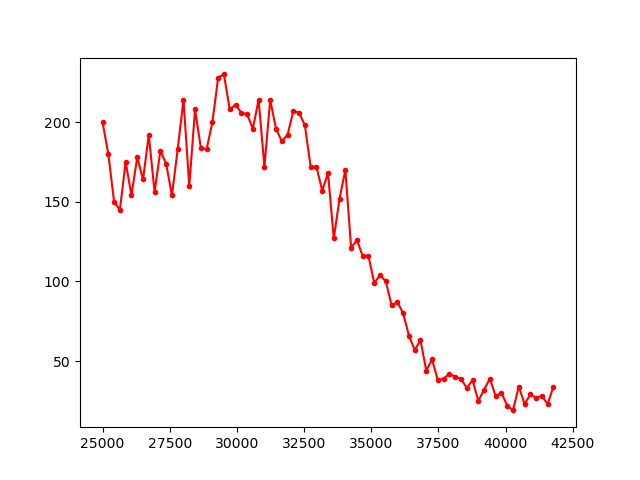

In [551]:
%matplotlib notebook
plt.plot(histX, histY, 'r.-')
plt.show()

### Curve fit for gaussian model

In [552]:
from scipy.optimize import curve_fit

def gaussianFunc(x, mu, sd):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sd, 2.)))

### Just some tests to check if fitting will work ok

In [553]:
xF = range(-100, 100, 1)
yF = [0]*len(xF)

for i in range(len(xF)):
    yF[i] = gaussianFunc(xF[i], 0, 100/np.sqrt(10))

<IPython.core.display.Javascript object>


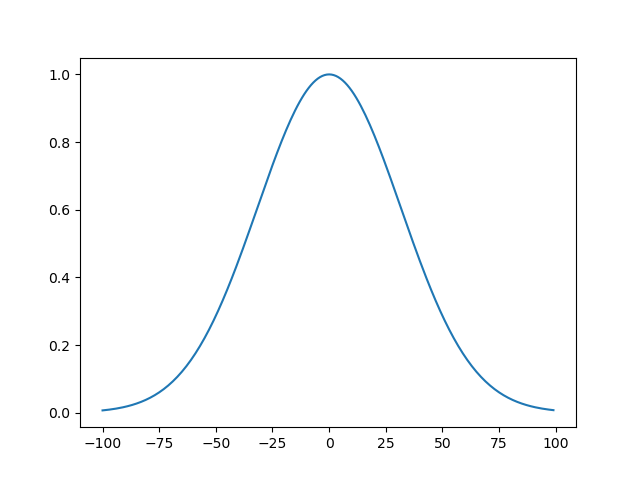

In [554]:
%matplotlib notebook
plt.plot(xF, yF)
plt.show()

## Fitting gaussian model

In [555]:
#Using least-squares method
popt, pcov = curve_fit(gaussianFunc, histX, histY, bounds = ([regionOfInterest[0], normDist.stdev - 100], [regionOfInterest[1], normDist.stdev + 100]))

distMean, distSD = popt

In [556]:
distMean

30359.255485658457

In [557]:
distSD

3930.527650236857

<IPython.core.display.Javascript object>


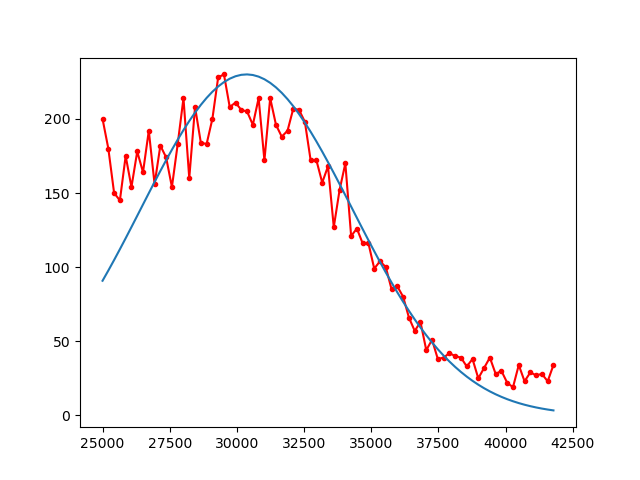

In [558]:
histFit = []
for i in histX:
    histFit.append(max(histY)*gaussianFunc(i, distMean, distSD))

%matplotlib notebook
plt.plot(histX, histY, 'r.-')
plt.plot(histX, histFit)
plt.show()

# Linear regression for energy calibration

## Using data from both sources

### Using min-squared error

In [409]:
#Simple way without SciKit Learn
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
  
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
  
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
  
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)

## Using SciKit Learn

In [11]:
# fittedCsHist = 4608.77
# fittedCoHist = 7120.88

# fittedCsStdErr = 375.51
# fittedCoStdErr = 726.90

fittedCsHist = 15224.48
fittedCoHist = 28316.39

fittedCsStdErr = 1992.93
fittedCoStdErr = 3980.94

realCsEnergyPeak = 661.7
realCoEnergyPeak = 1252.85

regressionIntercepts = []
regressionSlopes = []

In [410]:
# fittedCsHist = 4608.77
# fittedCoHist = 7120.88

# fittedCsStdErr = 375.51
# fittedCoStdErr = 726.90

fittedNaHist = 13014
fittedCsHist = 16985
fittedCoHist = 30148

fittedNaStdErr = 1504.9
fittedCsStdErr = 1561.9
fittedCoStdErr = 4048.5


realNaEnergyPeak = 511
realCsEnergyPeak = 661.7
realCoEnergyPeak = 1252.85

regressionIntercepts = []
regressionSlopes = []

## Linear regression with (0,0) "experimental" value - least-squared errors

In [411]:
dfRegression0 = pd.DataFrame()
dfRegression0["x"] = np.array([0, fittedNaHist, fittedCsHist, fittedCoHist])
dfRegression0["y"] = np.array([0, realNaEnergyPeak, realCsEnergyPeak, realCoEnergyPeak])
dfRegression0

x        y
0      0     0.00
1  13014   511.00
2  16985   661.70
3  30148  1252.85

In [412]:
X = dfRegression0.iloc[:, 0].values.reshape(-1, 1)
Y = dfRegression0.iloc[:, 1].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

<IPython.core.display.Javascript object>


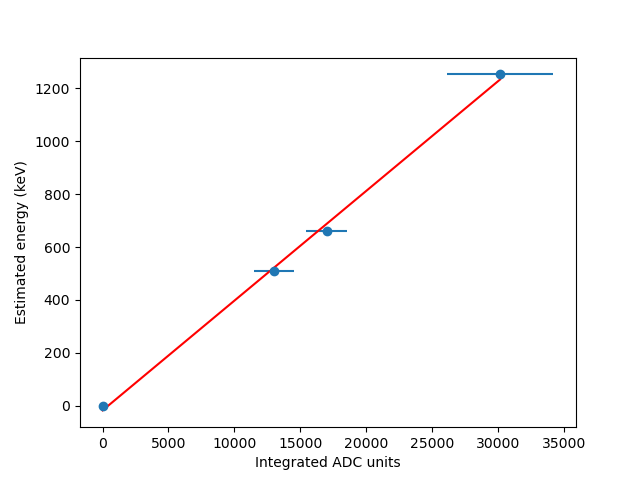

In [414]:
%matplotlib notebook
# plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=[0, fittedNaStdErr, fittedCsStdErr, fittedCoStdErr], fmt='o')
plt.plot(X, Y_pred, color = 'red')
plt.xlabel("Integrated ADC units")
plt.ylabel("Estimated energy (keV)")

plt.show()

In [415]:
aCoef = lr.coef_
bCoef = lr.intercept_

regressionSlopes.append(aCoef[0][0])
regressionIntercepts.append(bCoef[0])

In [416]:
print("Calibration curve [y = ax + b]")
print("y = " + "{:.5f}".format(aCoef[0][0]) + "x" + " + " + "{:.3f}".format(bCoef[0]))

Calibration curve [y = ax + b]
y = 0.04150x + -17.654


## Linear regression without (0,0) "experimental" value - least-squared errors

In [417]:
dfRegression1 = pd.DataFrame()
dfRegression1["x"] = np.array([fittedNaHist, fittedCsHist, fittedCoHist])
dfRegression1["y"] = np.array([realNaEnergyPeak, realCsEnergyPeak, realCoEnergyPeak])
dfRegression1

x        y
0  13014   511.00
1  16985   661.70
2  30148  1252.85

In [418]:
X = dfRegression1.iloc[:, 0].values.reshape(-1, 1)
Y = dfRegression1.iloc[:, 1].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

<IPython.core.display.Javascript object>


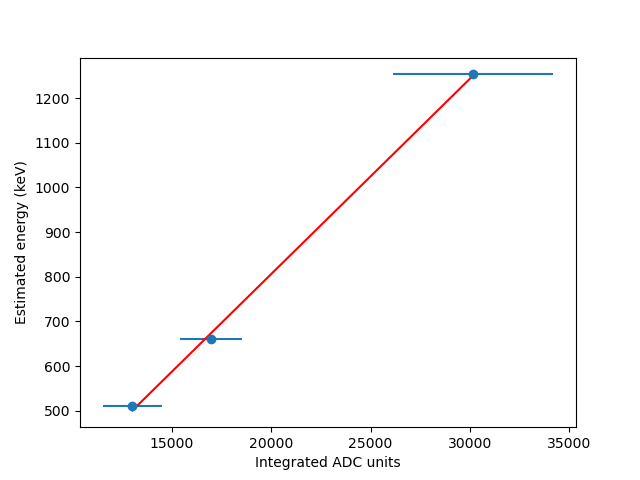

In [419]:
%matplotlib notebook
# plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=[fittedNaStdErr, fittedCsStdErr, fittedCoStdErr], fmt='o')
plt.plot(X, Y_pred, color = 'red')
plt.xlabel("Integrated ADC units")
plt.ylabel("Estimated energy (keV)")
plt.show()

In [420]:
aCoef = lr.coef_
bCoef = lr.intercept_

regressionSlopes.append(aCoef[0][0])
regressionIntercepts.append(bCoef[0])

In [421]:
print("Calibration curve [y = ax + b]")
print("y = " + "{:.5f}".format(aCoef[0][0]) + "x" + " + " + "{:.3f}".format(bCoef[0]))

Calibration curve [y = ax + b]
y = 0.04370x + -67.652



## Linear regression with forced (0,0) intercept - simple line fit with Co60

In [422]:
dfRegression2 = pd.DataFrame()
dfRegression2["x"] = np.array([0, fittedCoHist])
dfRegression2["y"] = np.array([0, realCoEnergyPeak])

In [423]:
X = dfRegression2.iloc[:, 0].values.reshape(-1, 1)
Y = dfRegression2.iloc[:, 1].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

<IPython.core.display.Javascript object>


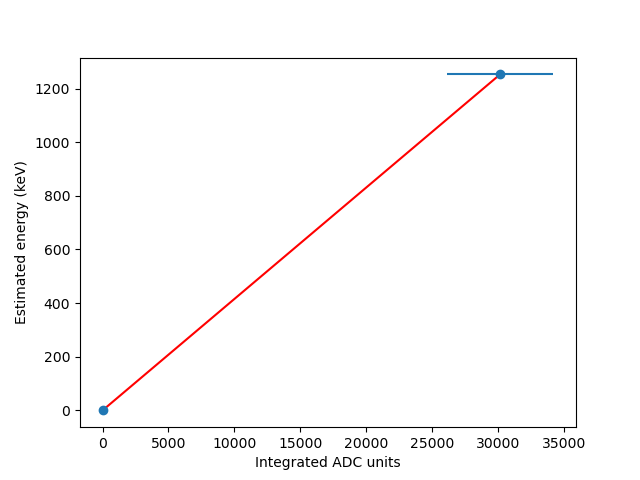

In [424]:
%matplotlib notebook
plt.errorbar(X, Y, xerr=[0, fittedCoStdErr], fmt='o')
plt.plot(X, Y_pred, color = 'red')
plt.xlabel("Integrated ADC units")
plt.ylabel("Estimated energy (keV)")
plt.show()

In [425]:
aCoef = lr.coef_
bCoef = lr.intercept_

regressionSlopes.append(aCoef[0][0])
regressionIntercepts.append(bCoef[0])

In [426]:
print("Calibration curve [y = ax + b]")
print("y = " + "{:.5f}".format(aCoef[0][0]) + "x" + " + " + "{:.3f}".format(bCoef[0]))

Calibration curve [y = ax + b]
y = 0.04156x + 0.000


## Linear regression with forced (0,0) intercept - simple line fit with Cs137

In [427]:
dfRegression3 = pd.DataFrame()
dfRegression3["x"] = np.array([0, fittedCsHist])
dfRegression3["y"] = np.array([0, realCsEnergyPeak])

In [428]:
X = dfRegression3.iloc[:, 0].values.reshape(-1, 1)
Y = dfRegression3.iloc[:, 1].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

<IPython.core.display.Javascript object>


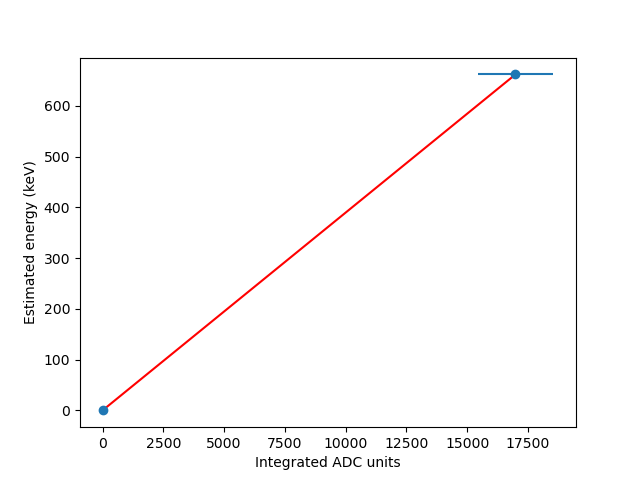

In [429]:
%matplotlib notebook
# plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=[0, fittedCsStdErr], fmt='o')
plt.plot(X, Y_pred, color = 'red')
plt.xlabel("Integrated ADC units")
plt.ylabel("Estimated energy (keV)")
plt.show()

In [430]:
aCoef = lr.coef_
bCoef = lr.intercept_

regressionSlopes.append(aCoef[0][0])
regressionIntercepts.append(bCoef[0])

In [431]:
print("Calibration curve [y = ax + b]")
print("y = " + "{:.5f}".format(aCoef[0][0]) + "x" + " + " + "{:.3f}".format(bCoef[0]))

Calibration curve [y = ax + b]
y = 0.03896x + 0.000


## Linear regression with forced (0,0) intercept - simple line fit with Na22

In [432]:
dfRegression4 = pd.DataFrame()
dfRegression4["x"] = np.array([0, fittedNaHist])
dfRegression4["y"] = np.array([0, realNaEnergyPeak])

In [433]:
X = dfRegression4.iloc[:, 0].values.reshape(-1, 1)
Y = dfRegression4.iloc[:, 1].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

<IPython.core.display.Javascript object>


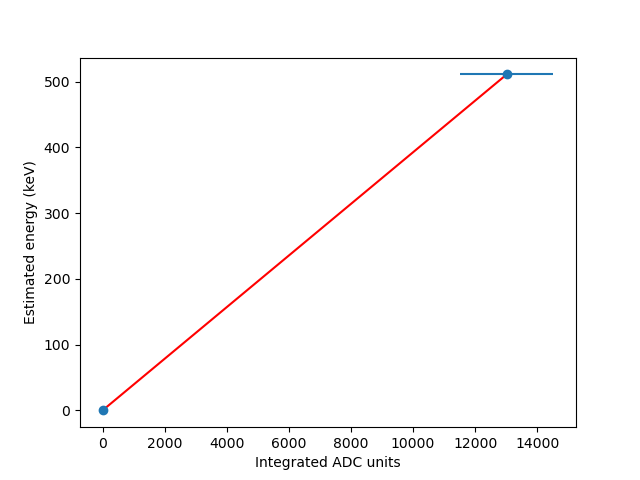

In [434]:
%matplotlib notebook
# plt.scatter(X, Y)
plt.errorbar(X, Y, xerr=[0, fittedNaStdErr], fmt='o')
plt.plot(X, Y_pred, color = 'red')
plt.xlabel("Integrated ADC units")
plt.ylabel("Estimated energy (keV)")
plt.show()

In [435]:
aCoef = lr.coef_
bCoef = lr.intercept_

regressionSlopes.append(aCoef[0][0])
regressionIntercepts.append(bCoef[0])

In [436]:
print("Calibration curve [y = ax + b]")
print("y = " + "{:.5f}".format(aCoef[0][0]) + "x" + " + " + "{:.3f}".format(bCoef[0]))

Calibration curve [y = ax + b]
y = 0.03927x + 0.000


## Wrapping up computed regressions

In [437]:
regressionSlopes

[0.041501109664643016,
 0.043701353389620674,
 0.041556653841050804,
 0.03895790403297027,
 0.039265406485323485]

In [438]:
regressionIntercepts

[-17.654310749820866,
 -67.65176744183816,
 1.1368683772161603e-13,
 5.684341886080802e-14,
 8.526512829121202e-14]

<IPython.core.display.Javascript object>


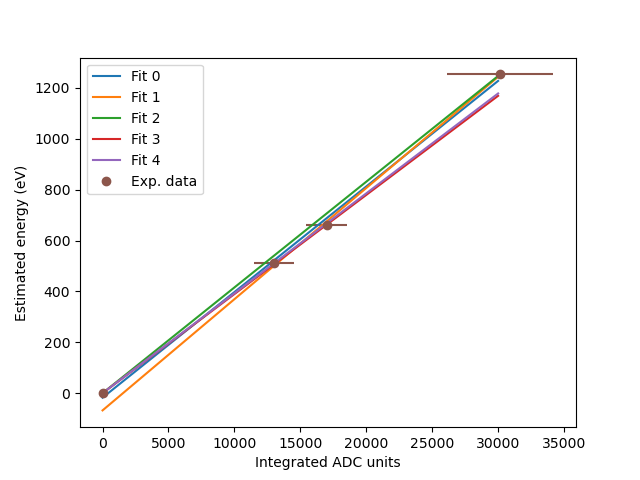

In [440]:
%matplotlib notebook
plots = [0]*len(regressionSlopes)
# xRange = range(0, 8000, 1)
xRange = range(0, 30000, 1)
for i in range(len(regressionSlopes)):
    plots[i],  = plt.plot(regressionSlopes[i]*xRange + regressionIntercepts[i], '-')


expPoints = plt.errorbar([0, fittedNaHist, fittedCsHist, fittedCoHist],
             [0, realNaEnergyPeak, realCsEnergyPeak, realCoEnergyPeak],
             xerr=[0, fittedNaStdErr, fittedCsStdErr, fittedCoStdErr], fmt='o')

legendList = [i for i in plots]
legendList.append(expPoints.get_children()[0])
legendText = [("Fit " + str(i)) for i in range(len(regressionSlopes))]
legendText.append("Exp. data")

plt.legend(legendList, legendText)
plt.xlabel("Integrated ADC units")
plt.ylabel("Estimated energy (eV)")
plt.show()

In [442]:
#Estimating calibration error
percentageError = (fittedNaStdErr/fittedNaHist + fittedCsStdErr/fittedCsHist + fittedCoStdErr/fittedCoHist)
percentageError

0.34188213088284847

In [443]:
#According to the previous calibration values, the mean calibration coefficients are (in the form y = ax + b)
aCalibrated = 0.0415
bCalibrated = -17.65

The calibration curve for these conditions is described as follows:

$y = (a \pm \Delta a)x + (b \pm \Delta b)$

Where 

$\Delta a = \Delta E \times a$

$\Delta b = \Delta E \times b$

and

$\Delta E = \frac{\Delta x_1}{x_1} + \frac{\Delta x_2}{x_2} $

Thus,

In [444]:
deltaA = percentageError*aCalibrated
deltaB = percentageError*bCalibrated

In [445]:
print("y = (" +
      "{:.3e}".format(aCalibrated) +
        " +/- " +
        "{:.3e}".format(deltaA) +
        ")x + (" +
        str(bCalibrated) +
        " -/+ " +
        "{:.2f}".format(deltaB) +
        ") eV" )

y = (4.150e-02 +/- 1.419e-02)x + (-17.65 -/+ -6.03) eV


## $$ E = ((41.50 \pm 14.19)\times 10^{-3} )x - (17.7 \mp 6.03)$$ 

<IPython.core.display.Javascript object>


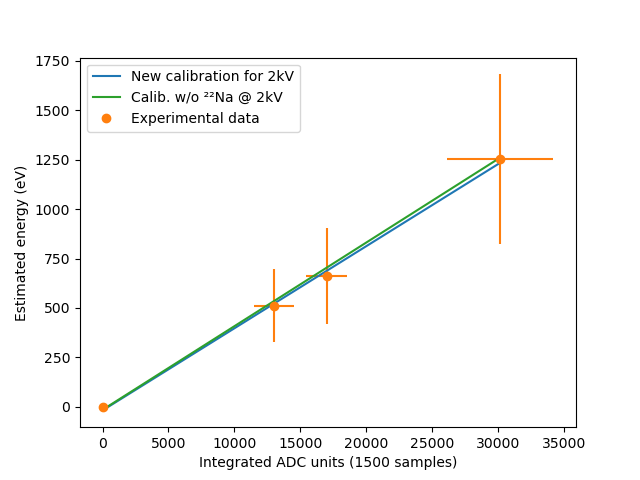

In [455]:
%matplotlib notebook
# xRange = range(0, 8000, 1)
xRange = range(0, 30000, 1)

plots, = plt.plot(aCalibrated * np.array(xRange) + bCalibrated, '-')

expPoints = plt.errorbar([0, fittedNaHist, fittedCsHist, fittedCoHist],
                        [0, realNaEnergyPeak, realCsEnergyPeak, realCoEnergyPeak],
                        xerr = [0, fittedNaStdErr, fittedCsStdErr, fittedCoStdErr],
                        yerr = [0, deltaA*fittedNaHist, deltaA*fittedCsHist, deltaA*fittedCoHist],
                                fmt = 'o')

previousplt, = plt.plot(0.04227*np.array(xRange) -14.7, '-')

legendList = [plots, previousplt]
legendList.append(expPoints.get_children()[0])
legendText = ["New calibration for 2kV", "Calib. w/o ²²Na @ 2kV", "Experimental data"]
plt.legend(legendList, legendText, loc = 2)




plt.xlabel("Integrated ADC units (1500 samples)")
plt.ylabel("Estimated energy (eV)")
plt.show()

# ==========================================

# Some tests with Plotly Graphics

In [36]:
import cufflinks as cf
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

%matplotlib notebook

nBins = computeNumberOfBins(len(dfConstrained), 0)


denormalization = 200
edgeCuts = 300

pdfX = range(roi[0]+edgeCuts, roi[1]-edgeCuts)
pdfY = norm.pdf(pdfX, dist[0], dist[1])
pdfY /= max(pdfY)




#Histogram and PDF definition using plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(

    go.Histogram(
                 x = dfConstrained[radionucleiName], histnorm = '',
                 nbinsx = nBins, marker_line = dict(width = 1),
                ),
    secondary_y = False,
    
)

fig.add_trace(
    go.Scatter(x = np.array(pdfX), y = pdfY, mode = 'lines'),
    secondary_y = True,
)

# fig.update_yaxes(type="log")
fig.show()



NameError: name 'computeNumberOfBins' is not defined

In [318]:
X2 = dfRegression.iloc[:, 0].values
Y2 = dfRegression.iloc[:, 1].values
Y_pred2 = Y_pred.reshape(3)

In [322]:
X2

array([   0.  , 4656.04, 7251.47])

In [323]:
Y_pred2 

array([ -33.16503168,  754.36103584, 1193.35399583])

In [321]:
#     fig = px.line(X2, Y_pred2)



fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = X2, y = Y_pred2, mode = "lines"),
    secondary_y = False,
    
)
    
fig.add_trace(
    go.Scatter(x = X2, y = Y2, mode = "markers", error_x = dict(type = 'data', array = [0, 400.0, 726.90], visible = True)),
    secondary_y = True,
)
fig.show()